In [1]:
import pandas as pd
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from ast import literal_eval

import pyLDAvis
import pyLDAvis.gensim

from core.plots import plot_topic_recurrences, plot_words_intopic

## Búsqueda de hiperparámetros para el modelo LDA

In [2]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, a=0.01, b=0.1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, 
                                                num_topics=num_topics, random_state=100,
                                                chunksize=100,passes=10, alpha=a, eta=b, per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Hyperparameter search results

def plot_hprms(values):
    import matplotlib.pyplot as plt
    limit=11; start=2; step=1;
    x = range(start, limit, step)
    plt.plot(x, values, c='k')
    plt.xlabel("Num Topics", fontsize=18)
    plt.axvline(x[np.argmax(values)], linestyle='--', c='r', label='optimal n topics')
    plt.ylabel("Coherence score", fontsize=18)
    plt.title('Topic Modeling LDA', fontsize=18)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Necesidades País

In [3]:
question = 'country' #country or personal

all_needs = pd.read_csv ('data/{}_needs.csv'.format(question))
all_needs['exp_tokens'] = all_needs['exp_tokens'].fillna('NR')
needs = all_needs[all_needs.exp_tokens!='NR'].copy()
tokens = np.array([literal_eval(token) for token in needs.exp_tokens])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [4]:
# Diccionario
id2word = corpora.Dictionary(tokens)

# Corpus
texts = tokens

# Frecuencia de términos de cada documento
corpus = [id2word.doc2bow(text) for text in texts]

In [5]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=tokens, start=2, limit=11, step=1)

max_ix = np.argmax(coherence_values)
plot_hprms(coherence_values)

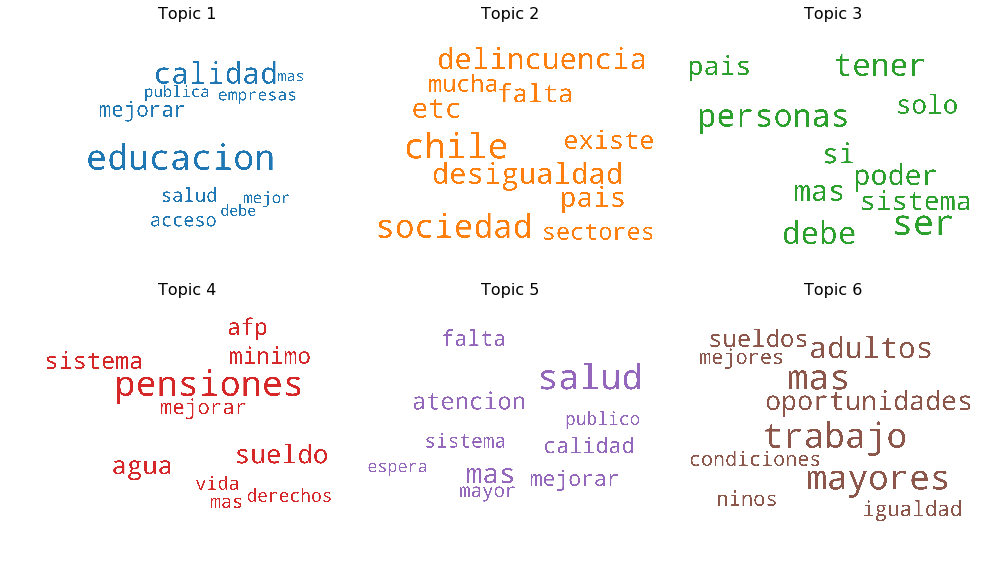

In [6]:
lda_model = model_list[max_ixs] #Best LDA Model
#lda_model = gensim.models.LdaMulticore.load('models/{}_lda.model'.format(question)) #If best model was saved.
plot_words_intopic(lda_model)

In [7]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=True)
pyLDAvis.display(lda_display)

In [8]:
def predict_topic(corpus, topic_dict):
    output = list(lda_model[corpus])[0]
    topics = sorted(output, key=lambda x:x[1], reverse=True)[0]
    return topic_dict[topics[0]]

In [11]:
### Mediante conocimiento experto, los topicos quedaron agrupados:

topic_dict = {
     0:'educacion',
     1:'cambios politicos',
     2:'pensiones',
     3:'pensiones',
     4:'salud',
     5:'condiciones laborales',
     6: 'vivienda y subsistencia',
    'NR': 'NR'
} 


preds = []

ix=0
for need in all_needs.exp_tokens:
    if need!='NR':
        pred = predict_topic(corpus[ix], topic_dict)
        preds.append(pred)
        ix+=1
    else:
        preds.append('NR')
all_needs['macro'] = preds 

all_needs.to_csv('data/{}_needs_macro.csv'.format(question), index=False)
lda_model.save('models/{}_lda.model'.format(question))

## Necesidades Personales

In [12]:
question = 'personal' #country or personal

all_needs = pd.read_csv ('data/{}_needs.csv'.format(question))
all_needs['exp_tokens'] = all_needs['exp_tokens'].fillna('NR')
needs = all_needs[all_needs.exp_tokens!='NR'].copy()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


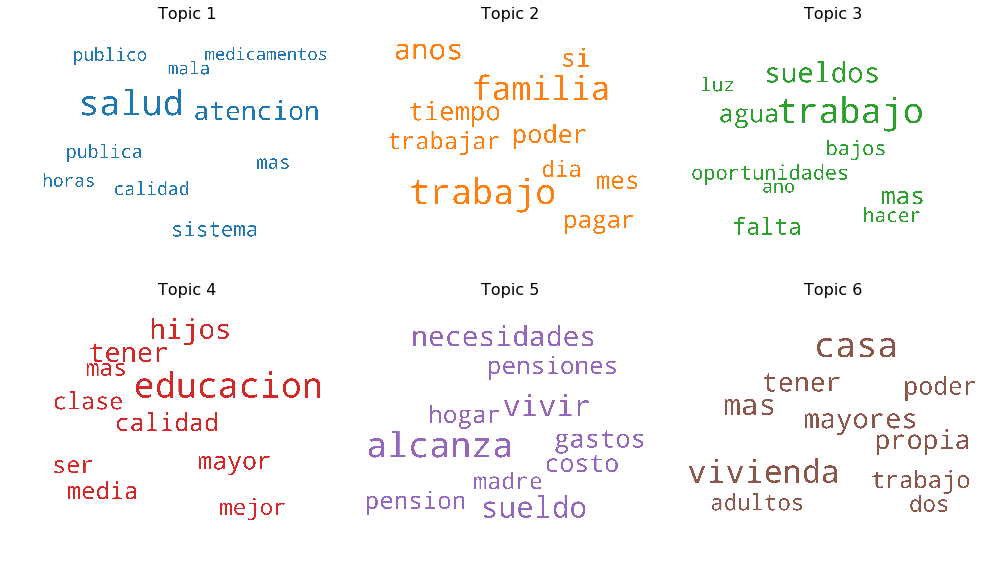

In [13]:
tokens = np.array([literal_eval(token) for token in needs.exp_tokens])
id2word = corpora.Dictionary(tokens)
texts = tokens
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.LdaMulticore.load('models/{}_lda.model'.format(question))
plot_words_intopic(lda_model)

In [ ]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=True) #Tpicos ordenados por recurrencia de palabras.
pyLDAvis.display(lda_display)

In [15]:
### Mediante conocimiento experto, los topicos quedaron agrupados:

topic_dict = {
    0:'salud',
    1:'familia',
    2:'escacez hidrica',
    3:'educacion',
    4:'sueldos y pensiones',
    5:'vivienda',
} 

preds = []

ix=0
for need in all_needs.exp_tokens:
    if need!='NR':
        pred = predict_topic(corpus[ix], topic_dict)
        preds.append(pred)
        ix+=1
    else:
        preds.append('NR')
all_needs['macro'] = preds 

all_needs.to_csv('data/{}_needs_macro.csv'.format(question), index=False)
lda_model.save('models/{}_lda.model'.format(question))